# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [3]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
import torch
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# TODO: add more transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_data = datasets.ImageFolder(root='/data/landmark_images/train', transform=transform)
test_data = datasets.ImageFolder(root='/data/landmark_images/test', transform=transform)

dataset_size = len(train_data)
dataset_indices = list(range(dataset_size))

np.random.shuffle(dataset_indices)

val_split_index = int(np.floor(valid_size * dataset_size))

train_idx, val_idx = dataset_indices[val_split_index:], dataset_indices[:val_split_index]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(val_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 

I resized and centered the images to end up with 224x224 images. This seems a reasonable size, not to big, but also preserves enough information.

I will go first without augumenting the dataset and see the results.

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

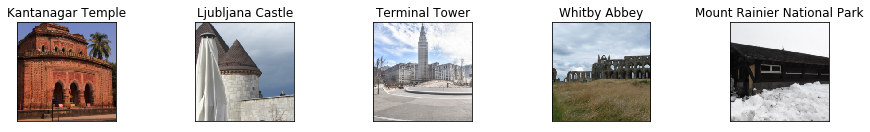

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

def get_label(index):
    label = train_data.classes[index]
    return label[3:].replace('_', ' ')

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(5):
    ax = fig.add_subplot(2, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(get_label(labels[idx]))


### Initialize use_cuda variable

In [5]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()
if use_cuda:
    print('Using GPU')
else:
    print('Using CPU')

Using GPU


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [6]:
## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    return optim.SGD(model.parameters(), lr=0.01)
    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [7]:
import torch.nn as nn

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        # dropout rate
        dropout = 0.25
        
        self.features = nn.Sequential(
            # 224 x 224 x 3 input
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # 112 x 112 x 16 input
            nn.Conv2d(16, 24, 3, padding=1),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # 56 x 56 x 24 input
            nn.Conv2d(24, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # 28 x 28 x 32 input
            nn.Conv2d(32, 48, 3, padding=1),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # 14 x 14 x 48 input
            nn.Conv2d(48, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
            # -> 64 * 7 * 7 = 3136
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(64 * 7 * 7, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1000, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 50)
        )
    
    def forward(self, x):
        ## Define forward behavior
        x = self.features(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.classifier(x)
        
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()
    
optimizer_scratch = get_optimizer_scratch(model_scratch)

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  
I will go at first with a basic implementation of 3 conv layers with a maxpool layer after each one.

>        # 224 x 224 x 3 input        
>        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
>        # 112 x 112 x 16 input
>        self.conv2 = nn.conv2d(16, 32, 3, padding=1)
>        # 56 x 56 x 16 input
>        self.conv3 = nn.conv2d(32, 64, 3, padding=1)
>        # max pooling layer
>        self.pool = nn.MaxPool2d(2, 2)
>        # linear layer (64 * 28 * 28 -> 50176)
>        self.fc1 = nn.Linear(64 * 28 * 28, 500)

Because the image sizes are large, I chose to remain with 224X224 pixels after resizing and croping, to preserve enough information. This way, the input of the fully conected layer ends up 50176.
This seems a bit high, so let's do some research. Both AlexNet and ResNet start with 224X224 images, but end up with a much lower input to the fully conected layers. I added more conv and maxpooling layers to reduce the size and 3 fully connected layers at the end.

After training the model, I noticed the validation is not decresing, so I added batch normalization after every layer and this fixed the problem.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [8]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

     
        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))


        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch,
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [7]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)


#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.894815 	Validation Loss: 3.723510
Validation loss decreased (inf --> 3.723510).  Saving model ...
Epoch: 2 	Training Loss: 3.695684 	Validation Loss: 3.563458
Validation loss decreased (3.723510 --> 3.563458).  Saving model ...
Epoch: 3 	Training Loss: 3.543087 	Validation Loss: 3.445972
Validation loss decreased (3.563458 --> 3.445972).  Saving model ...
Epoch: 4 	Training Loss: 3.427710 	Validation Loss: 3.360596
Validation loss decreased (3.445972 --> 3.360596).  Saving model ...
Epoch: 5 	Training Loss: 3.328342 	Validation Loss: 3.270395
Validation loss decreased (3.360596 --> 3.270395).  Saving model ...
Epoch: 6 	Training Loss: 3.241442 	Validation Loss: 3.140742
Validation loss decreased (3.270395 --> 3.140742).  Saving model ...
Epoch: 7 	Training Loss: 3.147012 	Validation Loss: 3.081939
Validation loss decreased (3.140742 --> 3.081939).  Saving model ...
Epoch: 8 	Training Loss: 3.061360 	Validation Loss: 3.075949
Validation loss decreased (3.08193

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [9]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 20

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.842707 	Validation Loss: 3.712102
Validation loss decreased (inf --> 3.712102).  Saving model ...
Epoch: 2 	Training Loss: 3.647046 	Validation Loss: 3.581998
Validation loss decreased (3.712102 --> 3.581998).  Saving model ...
Epoch: 3 	Training Loss: 3.505118 	Validation Loss: 3.494522
Validation loss decreased (3.581998 --> 3.494522).  Saving model ...
Epoch: 4 	Training Loss: 3.386312 	Validation Loss: 3.449429
Validation loss decreased (3.494522 --> 3.449429).  Saving model ...
Epoch: 5 	Training Loss: 3.276674 	Validation Loss: 3.290011
Validation loss decreased (3.449429 --> 3.290011).  Saving model ...
Epoch: 6 	Training Loss: 3.166297 	Validation Loss: 3.196977
Validation loss decreased (3.290011 --> 3.196977).  Saving model ...
Epoch: 7 	Training Loss: 3.050626 	Validation Loss: 3.144132
Validation loss decreased (3.196977 --> 3.144132).  Saving model ...
Epoch: 8 	Training Loss: 2.942222 	Validation Loss: 3.036229
Validation loss decreased (3.14413

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [10]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.481904


Test Accuracy: 38% (480/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [11]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}





### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [12]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    return optim.SGD(model.classifier.parameters(), lr=0.01)
    

    
    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [13]:
## TODO: Specify model architecture

model_transfer = models.vgg16(pretrained=True)

# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False
    
model_transfer.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 1000),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1000, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 50)
)


#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:07<00:00, 77569394.26it/s] 


__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__

I chose a VGG16 pretrained model and thought between changing the final layer of the classifier or changing the entire classifier. I decided to change the entire classifier because it seemed to steep to go from 1000 features to 50.
VGG16 had a good accuracy on ImageNet database, so I think it should also do well here.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [14]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
num_epochs = 20

model_transfer = train(num_epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), 
                      criterion_transfer, use_cuda, 'model_transfer.pt')


#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 3.864380 	Validation Loss: 3.735446
Validation loss decreased (inf --> 3.735446).  Saving model ...
Epoch: 2 	Training Loss: 3.508144 	Validation Loss: 3.059004
Validation loss decreased (3.735446 --> 3.059004).  Saving model ...
Epoch: 3 	Training Loss: 2.908364 	Validation Loss: 2.443932
Validation loss decreased (3.059004 --> 2.443932).  Saving model ...
Epoch: 4 	Training Loss: 2.371066 	Validation Loss: 2.041652
Validation loss decreased (2.443932 --> 2.041652).  Saving model ...
Epoch: 5 	Training Loss: 1.925719 	Validation Loss: 1.762726
Validation loss decreased (2.041652 --> 1.762726).  Saving model ...
Epoch: 6 	Training Loss: 1.559423 	Validation Loss: 1.546381
Validation loss decreased (1.762726 --> 1.546381).  Saving model ...
Epoch: 7 	Training Loss: 1.264214 	Validation Loss: 1.452615
Validation loss decreased (1.546381 --> 1.452615).  Saving model ...
Epoch: 8 	Training Loss: 1.012227 	Validation Loss: 1.356890
Validation loss decreased (1.45261

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [15]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.144854


Test Accuracy: 69% (869/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [16]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    model_transfer.load_state_dict(torch.load('model_transfer.pt'))
    model_transfer.eval()
    img = Image.open(img_path)
    input = transform(img)
    input = input.unsqueeze(0)
    if use_cuda:
        input = input.cuda()
    output = model_transfer(input)
    values,indices = output.topk(k)
    indices_np = indices.cpu().detach().numpy().flatten()
    result = list(map(lambda i: get_label(i), indices_np))
    return result


# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Golden Gate Bridge',
 'Forth Bridge',
 'Brooklyn Bridge',
 'Niagara Falls',
 'Dead Sea']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

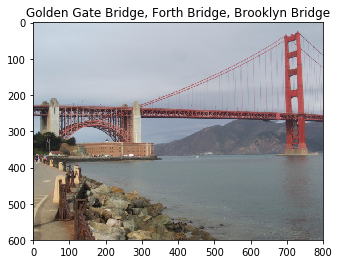

In [17]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    plt.title(', '.join(predicted_landmarks))
    plt.imshow(mpimg.imread(img_path))
    
    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

The images I chose are pretty representative, so I expect the algorithm to do well. Maybe some problems for Yellowstone, because it might be harder to identify a natural landscape. And after running the model, Yellowstone was indeed not recognized, and no problem for the others.

3 possible points of improvement:
- augument the data using transformations
- try with a different criterion and optimizer
- tune the hyperparameters

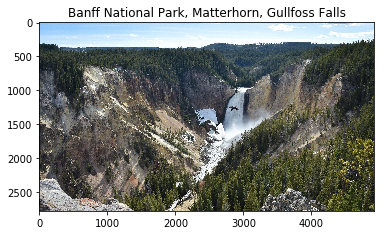

In [18]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

suggest_locations('images/local/yellow_stone_national_park.jpeg')

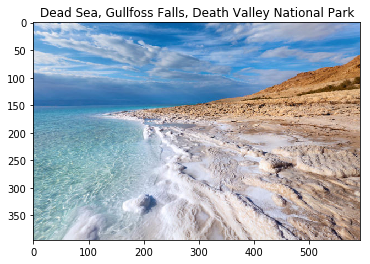

In [19]:
suggest_locations('images/local/dead_sea.jpeg')

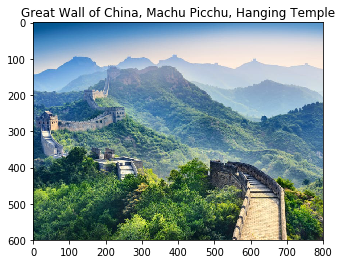

In [20]:
suggest_locations('images/local/great_wall_of_china.jpeg')

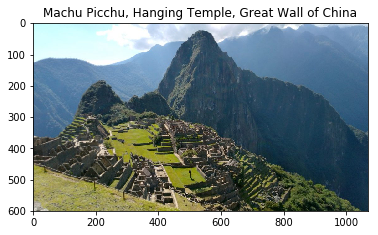

In [21]:
suggest_locations('images/local/machu_picchu.jpeg')